# Markov-Chain Monte Carlo For Calculating Hydrogen Gas Bond Length

In this notebook, we will use a Markov-Chain Monte Carlo (MCMC) approach to calculate the bond length of a hydrogen gas molecule at three different temperatures (10, 100, and 1000 K). This stocastic approach will not only show us the bond length, but the distribution of possible bond lengths. This allows us to see how the bond length can vary (especially at higher temperatures), which not only gives us the mean bond length, but its variability as well.

## Background
The hydrogen gas molecule system is *quantized*, which means that a bond length between the two hydrogen atoms corresponds to a discrete energy level. Which accessability of these energy states depend on the temperature of the system, i.e. higher energy states are accessible at higher temperatures. The accessability of these states follow a [Boltzmann probability distribution function](https://en.wikipedia.org/wiki/Boltzmann_distribution) (PDF).

It is very difficult to calculate the exact Boltzmann PDF directly, as every possible state needs to be calculated to normalize it. However, it is easy to calculate the ratio of two probabilities - *the Boltzmann factor*. Here a value larger than one means that the subseqeuent energy state is more probable than the last (or initial) state. We will use this choose which samples to pick in our MCMC algorithm. 

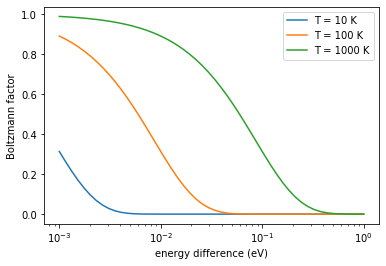

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from ase import units

def boltzmann_factor(energy_diff, temperature=298):
    return np.exp(-energy_diff/(units.kB*temperature))

fig, ax = plt.subplots()

temperatures = [10, 100, 1000] # Kelvin
energy_diff = np.logspace(-3,0) # energy difference between two states in eV

for temp in temperatures:
    ax.semilogx(energy_diff, boltzmann_factor(energy_diff, temperature=temp), label='T = %1.0f K' % temp)
    
ax.set(
    xlabel='energy difference (eV)',
    ylabel='Boltzmann factor'
)
plt.legend()

## The Algorithm

A naive way to calculate the bond length of a hydrogen molecule would be to sample all possible quantum states and try to recover the full Boltzmann distribution that way. However, like we mentioned this is very hard to calculate, so instead we will use the initial and current states, and use them to calculate the Boltzmann factor to sample from the distribution indirectly. 

In our algorithm we will:
1. Choose an initial configuration of atoms and calculate its potential energy (our initial state).
2. Propose a random-walk step for each atom. The atoms will be randomly moved in x, y, and z directions by picking a number between -1 and 1 for each coordinate. We will multiply this by a maximum step-size of 0.5 Å to avoid moving to far. This is Markov-Chain step.
3. Now we calculate the energy of the proposed step and then the Boltzmann factor of the proposed and initial configurations. If the factor is greater than 1, we accept the proposed step it, else we draw a random number between 0 and 1 and accept the step if the factor is greater than this random number.
4. Go back to 2 until a maximum of 2000 iterations have been completed. 

In [2]:
from ase.calculators.emt import EMT
from ase.io import Trajectory

class MCMC:
    def __init__(self, atoms, calculator=EMT(), temperature=298.0, max_step=0.5, iterations=2000):
        self.atoms = atoms # initial atom object
        self.calc = calculator # assigns calculator
        
        # algoritm parameters
        self.max_step = max_step # maximum step in Å
        self.T = temperature # system temperature
        self.iter = iterations # number of iterations or runs 
        
        # sets the calculator to the atoms object
        self.atoms.set_calculator(self.calc)
        
        # creates a trajectory object where we store accepted atom configurations
        self.accepted_traj = Trajectory('accepted_%1.0f.traj' % self.T, 'w')
        self.accepted_traj.write(atoms) # writes initial configuration
        
        
        self.energies = [atoms.get_potential_energy()] # empty list for storing accepted potential energies
        self.bond_lengths = [self.get_bond_length(atoms)] # same but for bond length

        return 
    
    def randomly_move(self, atoms):
        for atom in atoms:
            atom.x += self.max_step*np.random.uniform(low=-1,high=1)
            atom.y += self.max_step*np.random.uniform(low=-1,high=1)
            atom.z += self.max_step*np.random.uniform(low=-1,high=1)
        return atoms
    
    def get_bond_length(self, atoms):
        return atoms.get_distance(0,1)
    
    # returns the potential energy of the atoms object
    def get_energy(self, atoms):
        # gets the bond length in Å
        bond_length = self.get_bond_length(atoms)
        
        # returns infinite energy if the bond is too small or large, else calculates the potential energy
        if (bond_length < 0.35) or (bond_length > 6.0):
            energy = np.inf
        else:
            energy = atoms.get_potential_energy()
        return energy

    # method that decides if we accept the proposed step
    def accept_step(self, new_energy, old_energy):
        # calculates the boltzmann factor
        r = boltzmann_factor(new_energy-old_energy, temperature=self.T)
        
        # if the factor is greater than one we accept the step 
        # or if the factor is greater than a random number, we also accept the step
        if r > 1 or r > np.random.uniform(low=0,high=1):
            return True
        else:
            return False
        
    def run(self):
        initial_energy = self.energies[0]
        
        for _ in range(self.iter):
            proposed_atoms = self.atoms.copy() # copies the original atom object
            proposed_atoms.set_calculator(self.calc) # need to reapply the calculator (not copied)
            
            proposed_atoms = self.randomly_move(proposed_atoms) # randomly moves each atom in atoms
            
            # finds the potential energy of the moved atoms and their bond length
            proposed_energy = self.get_energy(proposed_atoms)
            
            previous_energy = self.energies[-1]
            
            if self.accept_step(proposed_energy, previous_energy):
                self.energies.append(proposed_energy)
                self.bond_lengths.append(self.get_bond_length(proposed_atoms))
                self.accepted_traj.write(proposed_atoms)
            else:
                continue
        return 
    
    def get_energies(self):
        return self.energy

# Calculating Hydrogen Bond Length

## Initial Configuration
We will use the [Atomistic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) to construct our hydrogen gas molecule, as well as for performing all electronic structure calculations.

In [3]:
from ase import Atoms
# creates a hydrogen gas molecule inside a cell (just a volume of space)
atoms = Atoms(
    'H2', # type of atoms (2 hydrogen)
    positions = [
        (0,0,0), # x, y, & z coordinates of atom 1
        (0,0,1.2) # atom 2
    ]
)
atoms.set_cell((15,15,15)) # makes the cell 15x15x15 Å 
atoms.center() # places the atoms in the center of the cell

## Generating Data
We'll now run the atoms object through our algorithm and record the bond lengths at three different temperatures - 10, 100, and 1000 K. 

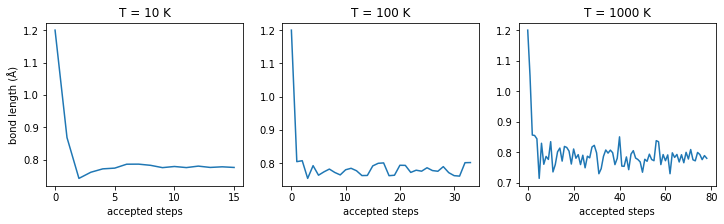

In [4]:
import pandas as pd 

# data storage dictionary
data={'temperature': [], 'bond_length': []}

fig, axes = plt.subplots(1,3, figsize=(12,3))

for temp, ax in zip(temperatures, axes):
    h2 = MCMC(atoms,temperature=temp)
    h2.run()
    E = h2.energies
    d = h2.bond_lengths
    
    data['bond_length'] += d
    data['temperature'] += np.repeat(temp, len(d)).tolist()
    ax.plot(d)
    ax.set(
        xlabel='accepted steps',
        title='T = %1.0f K' % temp,
    )

axes[0].set(
    ylabel='bond length (Å)',
)

# stores data in pandas dataframe
df = pd.DataFrame(data=data)

From these results we can draw some conclusions.
1. More steps are accepted at higher temperature; more energy states are accessible. 
2. The bond length fluctuates more at higher temperatures. 

### Boxplot & Summary Statistics
We can visualize the data as a boxplot, where we can clearly see how the average bond length and flucutations increase with temperature.

[Text(0, 0.5, 'bond length (Å)'), Text(0.5, 0, 'temperature (K)')]

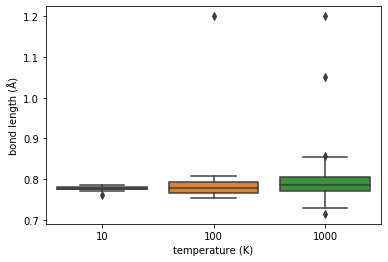

In [5]:
import seaborn as sns 

fig, ax = plt.subplots()

df = df.iloc[3:] # we remove the first few iterations
sns.boxplot(data=df, x='temperature', y='bond_length', ax=ax)

ax.set(
    xlabel='temperature (K)',
    ylabel='bond length (Å)',
)

In [6]:
df.groupby('temperature').describe()

bond_length                                                    \
                  count      mean       std       min       25%       50%   
temperature                                                                 
10                 13.0  0.777095  0.006486  0.761267  0.775462  0.776092   
100                34.0  0.792132  0.073568  0.753906  0.766091  0.777981   
1000               79.0  0.795370  0.062098  0.714709  0.770955  0.786737   

                                 
                  75%       max  
temperature                      
10           0.780163  0.786253  
100          0.792848  1.200000  
1000         0.804731  1.200000

From the summary statistics, we can see that the mean bond length is relatively consistent (as expected), but the standard deviation increases significantly with temperature. 

The mean bond lengths can be compared to a literature value of roughly 7.4 Å. The difference can be explained by our use of the EMT calculator, as this is by far the least accurate, but fastest, calculator in ASE, which is usually used for testing purposes. 